<a href="https://colab.research.google.com/github/shreyasingh2/stylelab-sandbox/blob/main/StyleLabV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe opencv-python numpy matplotlib


In [22]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

from mediapipe.framework.formats import landmark_pb2

mp_pose = mp.solutions.pose


def load_image(path):
    """
    Load an image from disk and return (BGR, RGB) versions.
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not load image at {path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, img_rgb


def draw_landmarks(image_rgb, landmarks):
    """
    Draw pose landmarks as small dots on the image and display it.
    """
    img = image_rgb.copy()
    h, w, _ = img.shape
    for lm in landmarks:
        x = int(lm.x * w)
        y = int(lm.y * h)
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


def euclidean_distance(a, b):
    """
    Euclidean distance between two MediaPipe landmarks in normalized coordinates.
    """
    return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2 + (a.z - b.z)**2)


def joint_angle(a, b, c):
    """
    Angle at point b formed by points a-b-c in degrees.
    Returns None if something is degenerate.
    """
    ba = np.array([a.x - b.x, a.y - b.y, a.z - b.z])
    bc = np.array([c.x - b.x, c.y - b.y, c.z - b.z])

    norm_ba = np.linalg.norm(ba)
    norm_bc = np.linalg.norm(bc)
    if norm_ba == 0 or norm_bc == 0:
        return None

    cos_angle = np.dot(ba, bc) / (norm_ba * norm_bc)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = math.degrees(math.acos(cos_angle))
    return angle


Upload a full-body image (PNG/JPG).


Saving b7670e4e-eee3-4ed1-96d8-ab4d790bb478.jpeg to b7670e4e-eee3-4ed1-96d8-ab4d790bb478 (15).jpeg

✅ Image uploaded successfully!
📍 IMAGE_PATH set to: /content/b7670e4e-eee3-4ed1-96d8-ab4d790bb478 (15).jpeg


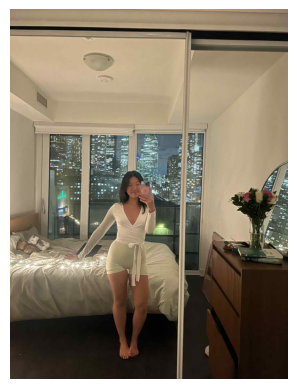

In [23]:
# 📤 Upload an image and set IMAGE_PATH automatically

from google.colab import files
import os

print("Upload a full-body image (PNG/JPG).")
uploaded = files.upload()

if uploaded:
    fname = list(uploaded.keys())[0]
    IMAGE_PATH = os.path.join("/content", fname)
    print(f"\n✅ Image uploaded successfully!")
    print(f"📍 IMAGE_PATH set to: {IMAGE_PATH}")

    # Load & show basic preview (optional)
    img_bgr, img_rgb = load_image(IMAGE_PATH)
    plt.imshow(img_rgb)
    plt.axis("off")
else:
    print("No file uploaded.")


In [4]:
## ✨ Feature Extraction

 ## From the pose landmarks we compute a **small, powerful feature set**:

 ## - `height` – nose to ankles (normalized distance)
 ## - `torso_leg_ratio` – torse length vs leg length
 ## - `shoulder_width` & `hip_width`
 ## - `shoulder_hip_ratio` – Yang vs Yin in width
 ## - `body_aspect_ratio` – tall vs compact in the frame
 ## - `joint_softness` – rough proxy for straight vs curved joints


In [24]:
def compute_body_features(landmarks):
    # MediaPipe Pose indices
    NOSE = 0
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    LEFT_HIP = 23
    RIGHT_HIP = 24
    LEFT_KNEE = 25
    RIGHT_KNEE = 26
    LEFT_ANKLE = 27
    RIGHT_ANKLE = 28
    LEFT_ELBOW = 13
    RIGHT_ELBOW = 14
    LEFT_WRIST = 15
    RIGHT_WRIST = 16

    l = landmarks  # shorthand

    # Midpoints: hips, shoulders, ankles
    mid_hips = landmark_pb2.NormalizedLandmark()
    mid_hips.x = (l[LEFT_HIP].x + l[RIGHT_HIP].x) / 2
    mid_hips.y = (l[LEFT_HIP].y + l[RIGHT_HIP].y) / 2
    mid_hips.z = (l[LEFT_HIP].z + l[RIGHT_HIP].z) / 2

    mid_shoulders = landmark_pb2.NormalizedLandmark()
    mid_shoulders.x = (l[LEFT_SHOULDER].x + l[RIGHT_SHOULDER].x) / 2
    mid_shoulders.y = (l[LEFT_SHOULDER].y + l[RIGHT_SHOULDER].y) / 2
    mid_shoulders.z = (l[LEFT_SHOULDER].z + l[RIGHT_SHOULDER].z) / 2

    mid_ankles = landmark_pb2.NormalizedLandmark()
    mid_ankles.x = (l[LEFT_ANKLE].x + l[RIGHT_ANKLE].x) / 2
    mid_ankles.y = (l[LEFT_ANKLE].y + l[RIGHT_ANKLE].y) / 2
    mid_ankles.z = (l[LEFT_ANKLE].z + l[RIGHT_ANKLE].z) / 2

    # --- CORE VERTICAL MEASUREMENTS ---

    # Total "height" (nose to ankles)
    height = euclidean_distance(mid_ankles, l[NOSE])

    # Leg length: hips → ankles (lower body)
    leg_length = euclidean_distance(mid_hips, mid_ankles)

    # Torso length: shoulders → hips (upper body / torso)
    torso_length = euclidean_distance(mid_shoulders, mid_hips)

    # Vertical ratio of legs vs torso (simple vertical body ratio)
    if torso_length == 0:
        torso_leg_ratio = None
    else:
        torso_leg_ratio = torso_length / leg_length  # >1 = long legs (Yang), <1 = longer torso (Yin)

    if height != 0:
        leg_height_ratio = leg_length / height       # % of height that is leg
        torso_height_ratio = torso_length / height   # % of height that is torso
    else:
        leg_height_ratio = None
        torso_height_ratio = None

    # --- WIDTH MEASUREMENTS ---

    shoulder_width = euclidean_distance(l[LEFT_SHOULDER], l[RIGHT_SHOULDER])
    hip_width = euclidean_distance(l[LEFT_HIP], l[RIGHT_HIP])
    shoulder_hip_ratio = None if hip_width == 0 else shoulder_width / hip_width

    # --- OVERALL BODY ASPECT (VERTICAL LINE) ---

    xs = [lm.x for lm in l]
    ys = [lm.y for lm in l]
    vertical_range = max(ys) - min(ys)
    horizontal_range = max(xs) - min(xs)
    body_aspect_ratio = None if horizontal_range == 0 else vertical_range / horizontal_range

    # --- JOINT SOFTNESS (ELBOW + KNEE ANGLES) ---

    left_elbow_angle = joint_angle(l[LEFT_SHOULDER], l[LEFT_ELBOW], l[LEFT_WRIST])
    right_elbow_angle = joint_angle(l[RIGHT_SHOULDER], l[RIGHT_ELBOW], l[RIGHT_WRIST])
    left_knee_angle = joint_angle(l[LEFT_HIP], l[LEFT_KNEE], l[LEFT_ANKLE])
    right_knee_angle = joint_angle(l[RIGHT_HIP], l[RIGHT_KNEE], l[RIGHT_ANKLE])

    angles = [a for a in [left_elbow_angle, right_elbow_angle,
                          left_knee_angle, right_knee_angle] if a is not None]

    if angles:
        avg_angle = sum(angles) / len(angles)
        # Distance from 180° (perfectly straight) – rough "softness" proxy
        joint_softness = abs(180 - avg_angle)
    else:
        joint_softness = None

    features = {
        # vertical proportions
        "height": height,
        "leg_length": leg_length,
        "torso_length": torso_length,
        "torso_leg_ratio": torso_leg_ratio,
        "leg_height_ratio": leg_height_ratio,
        "torso_height_ratio": torso_height_ratio,

        # width / balance
        "shoulder_width": shoulder_width,
        "hip_width": hip_width,
        "shoulder_hip_ratio": shoulder_hip_ratio,

        # vertical line & sharpness
        "body_aspect_ratio": body_aspect_ratio,
        "joint_softness": joint_softness,
    }
    return features



In [25]:
## 🧮 Rule-Based Kibbe "Lane" Classifier (MVP)

## This is a **very simple, adjustable ruleset**:

## - Computes **YANG vs YIN** score from:
  ## - vertical line (aspect)
  ## - leg:torso
  ## - shoulder vs hip dominance
  ## - joint softness (optional, rough)

## - Then maps patterns to **broad Kibbe neighborhoods**:
  ## - Dramatic spectrum / Soft Dramatic
  ## - Flamboyant Natural / Soft Natural
  ## - Romantic / Theatrical Romantic
  ## - Gamine / Soft Gamine
  ## - Classic-ish / balanced


In [26]:
def classify_kibbe(features):
    leg_torso = features["torso_leg_ratio"]
    sh_hip = features["shoulder_hip_ratio"]
    aspect = features["body_aspect_ratio"]
    shoulder_w = features["shoulder_width"]
    hip_w = features["hip_width"]
    joint_softness = features["joint_softness"]

    yang = 0
    yin = 0

    # --- Vertical line (aspect ratio) ---
    if aspect is not None:
        if aspect > 1.6:
            yang += 1
        if aspect > 2.0:
            yang += 1
        if aspect < 1.4:
            yin += 1

    # --- Leg vs torso ---
    if leg_torso is not None:
        if leg_torso > 1.1:
            yang += 1
        elif leg_torso < 0.95:
            yin += 1

    # --- Shoulder vs hip ratio ---
    if sh_hip is not None:
        if sh_hip > 1.1:
            yang += 1
        elif sh_hip < 0.95:
            yin += 1

    # --- Width dominance ---
    if shoulder_w is not None and hip_w is not None:
        if shoulder_w > hip_w * 1.05:
            yang += 1
        elif hip_w > shoulder_w * 1.05:
            yin += 1

    # --- Softness analysis: from joint_softness & hips ---
    softness_level = "unknown"
    softness_desc = ""
    softness_comment = "N/A"

    if joint_softness is not None:
        # joint_softness ≈ 0–90 (0 = very straight/taut, higher = more bent/soft)
        if joint_softness < 8:
            softness_level = "sharp / taut"
            softness_comment = "Lines read relatively straight and tight."
        elif joint_softness < 20:
            softness_level = "moderately soft"
            softness_comment = "There is some softness/relaxation in the limbs."
        else:
            softness_level = "very soft"
            softness_comment = "Limbs read quite soft/relaxed, less taut overall."
    else:
        softness_comment = "Not enough joint data to estimate softness."

    softness_desc = softness_comment

    # Flesh softness hint via hips vs shoulders
    if hip_w is not None and shoulder_w is not None:
        if hip_w > shoulder_w * 1.05:
            softness_desc += " The lower body reads a bit fuller/curvier."
        elif shoulder_w > hip_w * 1.05:
            softness_desc += " The upper body reads straighter/shoulder-dominant."

    # Softness also contributes one Yin/Yang vote
    if joint_softness is not None:
        if joint_softness > 12:
            yin += 1
        elif joint_softness < 6:
            yang += 1

    delta = yang - yin
    kibbe_guess = "Classic / Gamine mix"
    explanation = []

    # --- Kibbe lane mapping ---
    if delta >= 3:
        if hip_w is not None and hip_w >= shoulder_w * 0.95:
            kibbe_guess = "Soft Dramatic spectrum"
            explanation.append("Strong Yang with some Yin softness in hips → Soft Dramatic lane.")
        else:
            kibbe_guess = "Dramatic spectrum"
            explanation.append("Strong Yang vertical & shoulders, straighter hips → Dramatic lane.")
    elif 1 <= delta < 3:
        if shoulder_w is not None and (features["height"] or 1e-6) != 0 and shoulder_w / (features["height"] + 1e-6) > 0.23:
            kibbe_guess = "Flamboyant Natural spectrum"
            explanation.append("Broad, slightly blunt frame with moderate Yang → Flamboyant Natural lane.")
        else:
            kibbe_guess = "Soft Natural / Classic mix"
            explanation.append("Moderate Yang with some softness → Soft Natural / Classic mix.")
    elif delta <= -3:
        kibbe_guess = "Romantic spectrum"
        explanation.append("Strong Yin dominance → Romantic / Theatrical Romantic lane.")
    elif -3 < delta <= -1:
        kibbe_guess = "Soft Gamine / Romantic mix"
        explanation.append("Some Yin dominance with compactness or softness → Soft Gamine / Romantic mix.")
    else:
        kibbe_guess = "Classic / Gamine mix"
        explanation.append("Yin and Yang relatively balanced → Classic / some Gamine influence.")

        # --- Build summary text ---
    explanation.insert(0, f"Kibbe family: {kibbe_guess}")
    explanation.insert(1, f"Yang vs Yin: {yang} vs {yin} (Δ = {delta})")
    explanation.append(f"Softness level: {softness_level}")

    torso_leg = features.get("torso_leg_ratio")
    sh_hip = features.get("shoulder_hip_ratio")
    aspect = features.get("body_aspect_ratio")
    joint_softness = features.get("joint_softness")

    if torso_leg is not None:
      explanation.append(f"Torso:Leg ratio ≈ {torso_leg:.2f}")
    if sh_hip is not None:
      explanation.append(f"Shoulder:Hip ratio ≈ {sh_hip:.2f}")
    if aspect is not None:
      explanation.append(f"Body aspect (height:width) ≈ {aspect:.2f}")
    if joint_softness is not None:
      explanation.append(f"Joint softness proxy ≈ {joint_softness:.1f}")

    explanation.append(softness_desc)

    return {
        "primary_type": kibbe_guess,
        "yang_score": yang,
        "yin_score": yin,
        "score_delta": delta,
        "softness_level": softness_level,
        "softness_description": softness_desc,
        "score_summary": "\n".join(explanation),
        "features": features,
    }



In [27]:
def kibbe_from_image(path, show_landmarks=True, verbose=False):
    """
    Full pipeline:
    - Load image
    - Extract pose landmarks
    - Compute body features
    - Classify Kibbe lane
    """
    bgr, rgb = load_image(path)
    lms = get_pose_landmarks(rgb)
    if lms is None:
        print("No pose detected. Try a clearer full-body, standing image.")
        return None

    feats = compute_body_features(lms)
    res = classify_kibbe(feats)

    # 🟣 Print the full summary from the classifier
    print("✨ Kibbe Analysis Summary")
    print("------------------------")
    print(res["score_summary"])

    # Optional: dump raw features if you want to debug numbers
    if verbose:
        print("\n🧪 Raw feature values:")
        for k, v in feats.items():
            print(f"{k}: {v}")

    if show_landmarks:
        draw_landmarks(rgb, lms)

    return res, lms, rgb



In [29]:
def get_pose_landmarks(image_rgb):
    """
    Run MediaPipe Pose on an RGB image and return the list of 33 pose landmarks,
    or None if no pose is detected.
    """
    with mp_pose.Pose(static_image_mode=True, model_complexity=1) as pose:
        results = pose.process(image_rgb)
        if not results.pose_landmarks:
            return None
        return results.pose_landmarks.landmark


Upload a full-body image (standing, head-to-feet visible):


Saving b7670e4e-eee3-4ed1-96d8-ab4d790bb478.jpeg to b7670e4e-eee3-4ed1-96d8-ab4d790bb478 (16).jpeg
Using image: /content/b7670e4e-eee3-4ed1-96d8-ab4d790bb478 (16).jpeg
✨ Kibbe Analysis Summary
------------------------
Kibbe family: Soft Natural / Classic mix
Yang vs Yin: 3 vs 2 (Δ = 1)
Moderate Yang with some softness → Soft Natural / Classic mix.
Softness level: very soft
Torso:Leg ratio ≈ 0.47
Shoulder:Hip ratio ≈ 1.49
Body aspect (height:width) ≈ 1.71
Joint softness proxy ≈ 74.4
Limbs read quite soft/relaxed, less taut overall. The upper body reads straighter/shoulder-dominant.


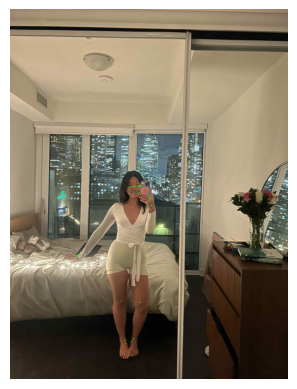

In [30]:
from google.colab import files
import os

print("Upload a full-body image (standing, head-to-feet visible):")
uploaded = files.upload()

for fname in uploaded.keys():
    IMAGE_PATH = os.path.join("/content", fname)
    print("Using image:", IMAGE_PATH)
    res, lms, rgb = kibbe_from_image(IMAGE_PATH, show_landmarks=True)